# CO2吸収・脱離の解析のための各種クラスや関数の定義をする
InsightCsvHandlerを作るほうがいい
1. CO2AbsExp
2. CO2DspExp

In [4]:
import csv, datetime, math, os
import numpy as np
from itertools import zip_longest


class CO2AbsExp:
    """
    path
    gas_conc | input in % unit
    flow_speed | input in ccm unit
    metadata
    timestamp
    elapsed
    conc
    """
    def __init__(self):
        pass
    
    def set_csv(self, path, data_starts):
        self.path = os.path.abspath(path)
        data = self.__open_csv(path)
        t = list(zip_longest(*data[data_starts:], fillvalue=""))
        self.timestamp = [datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in list(t[0])]
        time_start = self.timestamp[0]
        self.elapsed = {"unit": "sec", "time": [(i-time_start).total_seconds() for i in self.timestamp]}
        self.conc = {"unit": "%" if data[5][0]=="GMP251" else "ppm", "value": [self.__num_convert(j) for j in list(t[1])]}
        self.metadata = {
            "insight_version": data[0][1],
            "generated": datetime.datetime.strptime(data[1][1], "%Y-%m-%d %H:%M:%S"),
            "started": datetime.datetime.strptime(data[2][1], "%Y-%m-%d %H:%M:%S"),
            "ended": datetime.datetime.strptime(data[3][1], "%Y-%m-%d %H:%M:%S"),
            "probe": data[5][0],
            "serial": data[5][1],
            "probe_version": data[5][2],
            "sampling_time": self.elapsed["time"][1],
            "sampling_point": len(self.elapsed["time"])
        }
        self.has_applied = False
        return self
    
    def set_gas_conc(self, gas_conc):
        self.gas_conc = gas_conc
        return self
    
    def set_flow_rate(self, flow_rate):
        self.flow_rate = flow_rate
        return self
    
    def __open_csv(self, path):
        with open(path, "r", encoding='utf_8_sig') as f:
            csvreader = csv.reader(f)
            all_data = [row for row in csvreader]
        return all_data
    
    def __num_convert(self, s):
        try:
            r = float(s)
        except ValueError:
            return None
        else:
            return r
    
    def set_interval_average(self, interval_sec):
        if self.has_applied:
            if interval_sec % self.metadata_applied["sampling_time"] != 0 & interval_sec < self.metadata_applied["sampling_time"]:
                raise ValueError("Argument 'interval_sec' must be non-negative integer multiple of sampling_time.\nIn this case, sampling_time="+str(self.metadata_applied["sampling_time"]))
            interval = int(interval_sec // self.metadata_applied["sampling_time"])
            r=[]
            i = 0
            while True:
                if i >= self.metadata_applied["sampling_point"]:
                    break
                r.append(np.mean(self.conc_applied["value"][i:i+interval]))
                i+=interval
            self.metadata_applied["sampling_time"] = interval_sec
            self.metadata_applied["sampling_point"] = math.ceil(self.metadata_applied["sampling_point"] / interval)
            self.elapsed_applied = {"unit": "sec", "time": self.elapsed_applied["time"][::interval]}
            self.conc_applied = {"unit": self.conc_applied["unit"], "value": r}
        else:
            if interval_sec % self.metadata["sampling_time"] != 0 & interval_sec < self.metadata["sampling_time"]:
                raise ValueError("Argument 'interval_sec' must be non-negative integer multiple of sampling_time.\nIn this case, sampling_time="+str(self.metadata["sampling_time"]))
            interval = int(interval_sec // self.metadata["sampling_time"])
            r=[]
            i = 0
            while True:
                if i >= self.metadata["sampling_point"]:
                    break
                r.append(np.mean(self.conc["value"][i:i+interval]))
                i+=interval
            self.metadata_applied = self.metadata
            self.metadata_applied["sampling_time"] = interval_sec
            self.metadata_applied["sampling_point"] = math.ceil(self.metadata["sampling_point"] / interval)
            self.elapsed_applied = {"unit": "sec", "time": self.elapsed["time"][::interval]}
            self.conc_applied = {"unit": self.conc["unit"], "value": r}
            self.has_applied = True
        return self
    
    def set_normalize(self, minimum, maximum):
        if self.has_applied:
            mn = self.conc_applied["value"][np.argmin(self.conc_applied["value"])]
            mx = self.conc_applied["value"][np.argmax(self.conc_applied["value"])]
            diff = mx-mn
            self.conc_applied["value"] = [(i-mn)/diff*(maximum-minimum)+minimum for i in self.conc_applied["value"]]
        else:
            mn = self.conc["value"][np.argmin(self.conc["value"])]
            mx = self.conc["value"][np.argmax(self.conc["value"])]
            diff = mx-mn
            self.conc_applied = {"unit": self.conc["unit"], "value": [(i-mn)/diff*(maximum-minimum)+minimum for i in self.conc["value"]]}
            self.elapsed_applied = self.elapsed
            self.metadata_applied = self.metadata
            self.has_applied = True
        return self
    
    def set_timeunit(self, unit):
        cu = self.elapsed["unit"]
        cn = [2, 1, 0][(cu=="sec") + (cu in ["sec", "min"]) + (cu in ["sec", "min", "hour"]) - 1]
        sn = [2, 1, 0][(unit=="sec") + (unit in ["sec", "min"]) + (unit in ["sec", "min", "hour"]) - 1]
        conv = [1, 60, 3600, 1/3600, 1/60][cn-sn]
        self.elapsed["time"] = [i*conv for i in self.elapsed["time"]]
        self.elapsed["unit"] = unit
        if self.has_applied:
            cu = self.elapsed_applied["unit"]
            cn = [2, 1, 0][(cu=="sec") + (cu in ["sec", "min"]) + (cu in ["sec", "min", "hour"]) - 1]
            sn = [2, 1, 0][(unit=="sec") + (unit in ["sec", "min"]) + (unit in ["sec", "min", "hour"]) - 1]
            conv = [1, 60, 3600, 1/3600, 1/60][cn-sn]
            self.elapsed_applied["time"] = [i*conv for i in self.elapsed_applied["time"]]
            self.elapsed_applied["unit"] = unit
        return self
            
    
    def calc_co2re(self):
        if self.has_applied:
            data = self.conc_applied["value"] if self.conc_applied["unit"] == "%" else [i/10000 for i in self.conc_applied["value"]]
            self.co2re = [(self.gas_conc-i)/self.gas_conc*100 for i in data]
        else:
            data = self.conc["value"] if self.conc["unit"] == "%" else [i/10000 for i in self.conc["value"]]
            self.co2re = [(self.gas_conc-i)/self.gas_conc*100 for i in data]
        return self
    
    def calc_co2loading(self):
        self.calc_co2re()
        l = self.metadata_applied["sampling_point"] if self.has_applied else self.metadata["sampling_point"]
        t = self.metadata_applied["sampling_time"] if self.has_applied else self.metadata["sampling_time"]
        partial_loading = [0]
        integral_loading = [0]
        integral = 0
        for i in range(0, l-1):
            e = np.mean(self.co2re[i:i+1])
            partial = self.flow_rate*t*self.gas_conc*e/22.4/6/(10**8)
            partial_loading.append(partial)
            integral += partial
            integral_loading.append(integral)
        self.loading_p = partial_loading
        self.loading_i = integral_loading
        return self
        # (prev_eff+eff)/2/100*co2conc*flowrate/1000/12/22.4*1000
    
    def get_co2load(self):
        try:
            return self.loading_i[-1]
        except AttributeError:
            self.calc_co2loading()
            return self.loading_i[-1]
        
    def delete_analyzed(self):
        self.has_applied = False
        return self

sample: 16.20371705834531
Blank : 10.171038205722947
diffs : 6.032678852622361


C:\Users\yagi\AppData\Local\Temp\ipykernel_41008\3244666652.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


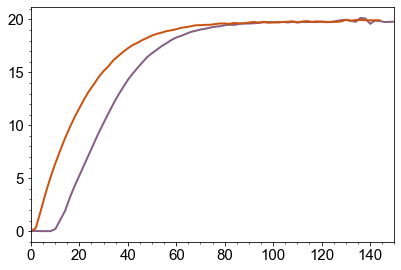

In [16]:
from matplotlib import pyplot as plt

abs_sample = r"C:\Users\yagi\OneDrive - 東京都公立大学法人\Research\theme\2212\14_3mmol_15ml_ss_abs\3mmol_15ml_DMSO_ss_abs_raw.csv"
s = CO2AbsExp().set_csv(abs_sample, 10).set_flow_rate(50.09).set_gas_conc(20.15)
s.set_interval_average(120)
s.set_timeunit("min")
s.set_normalize(0,20.15)

abs_blank = r"C:\Users\yagi\OneDrive - 東京都公立大学法人\Research\theme\2212\14_3mmol_15ml_ss_abs\blank_15ml_DMSO_ss_abs_raw.csv"
b = CO2AbsExp().set_csv(abs_blank, 10).set_flow_rate(50.09).set_gas_conc(19.96)
b.set_interval_average(120)
b.set_timeunit("min")
b.set_normalize(0,19.96)

print("sample: "+str(s.get_co2load()*1000))
print("Blank : "+str(b.get_co2load()*1000))
print("diffs : "+str(s.get_co2load()*1000-b.get_co2load()*1000))

def graph_gen(xydata, plot_range, xlabel, ylabel, norm=False, space=1):
    fig = plt.figure()
    
    # font設定
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 15
    
    # color設定
    color_table = ["#856084", "#ca5310", "#5575c7", "#16735a", "#e4b334"]
    color_used = 0
    length = len(xydata)
    
    if norm:
        plt.xlabel(xlabel)
        plt.ylabel("Normalized " + ylabel)
        index = 0
        for i in xydata:
            plt.plot(i["x"], series_norm(i["y"], index), color=color_table[color_used%5], lw=2, label=i["name"])
            color_used += 1
            index += space
    else:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        for i in xydata:
            plt.plot(i["x"], i["y"], color=color_table[color_used%5], lw=2, label=i["name"])
            color_used += 1
    #plt.legend(bbox_to_anchor=(1, 1.1), loc='best', borderaxespad=0.5, fontsize=15)
    plt.minorticks_on()
    if plot_range is not None:
        plt.xlim(plot_range[0], plot_range[1])
    plt.tight_layout()
    Export_filename = r"C:\Users\yagi\OneDrive - 東京都公立大学法人\Research\theme\2212\14_3mmol_15ml_ss_abs\graph.png"
    fig.patch.set_alpha(1)
    fig.show()
    fig.savefig(Export_filename, transparent=True, dpi = 400)


graph_gen([{"name": "Sample", "x": s.elapsed_applied["time"], "y": s.conc_applied["value"]}, {"name": "Blank", "x": b.elapsed_applied["time"], "y": b.conc_applied["value"]}], [0,150], "", "", norm=False, space=1)

In [5]:
import csv, datetime, math
import numpy as np
from itertools import zip_longest


class CO2DspExp:
    """
    path
    gas_conc | input in % unit
    flow_speed | input in ccm unit
    metadata
    timestamp
    elapsed
    conc
    """
    def __init__(self):
        pass
    
    def set_csv(self, path, data_starts):
        self.path = os.path.abspath(path)
        data = self.__open_csv(path)
        t = list(zip_longest(*data[data_starts:], fillvalue=""))
        self.timestamp = [datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in list(t[0])]
        time_start = self.timestamp[0]
        self.elapsed = {"unit": "sec", "time": [(i-time_start).total_seconds() for i in self.timestamp]}
        self.conc = {"unit": "%" if data[5][0]=="GMP251" else "ppm", "value": [self.__num_convert(i, j) for i, j in zip(list(t[1]), list(t[2]))]}
        self.metadata = {
            "insight_version": data[0][1],
            "generated": datetime.datetime.strptime(data[1][1], "%Y-%m-%d %H:%M:%S"),
            "started": datetime.datetime.strptime(data[2][1], "%Y-%m-%d %H:%M:%S"),
            "ended": datetime.datetime.strptime(data[3][1], "%Y-%m-%d %H:%M:%S"),
            "probe": data[5][0],
            "serial": data[5][1],
            "probe_version": data[5][2],
            "sampling_time": self.elapsed["time"][1],
            "sampling_point": len(self.elapsed["time"])
        }
        self.has_applied = False
        return self
    
    def set_flow_rate(self, flow_rate):
        self.flow_rate = flow_rate
        return self
    
    def __open_csv(self, path):
        with open(path, "r", encoding='utf_8_sig') as f:
            csvreader = csv.reader(f)
            all_data = [row for row in csvreader]
        return all_data
    
    def __num_convert(self, i,j):
        try:
            ir = float(i)
            if j == "null":
                return ir
            jr = float(j)
        except ValueError:
            return None
        else:
            return jr/10000 if jr < 20000 else ir
    
    def __time_convert(self, t):
        try:
            return datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S")
        except ValueError:
            return datetime.datetime.strptime(t, "%Y/%m/%d %H:%M:%S")
    
    def __none_clarify(self, s):
        if s is None:
            return 0
        else:
            return s
    
    def set_interval_average(self, interval_sec):
        if self.has_applied:
            if interval_sec % self.metadata_applied["sampling_time"] != 0 & interval_sec < self.metadata_applied["sampling_time"]:
                raise ValueError("Argument 'interval_sec' must be non-negative integer multiple of sampling_time.\nIn this case, sampling_time="+str(self.metadata_applied["sampling_time"]))
            interval = int(interval_sec // self.metadata_applied["sampling_time"])
            r=[]
            i = 0
            while True:
                if i >= self.metadata_applied["sampling_point"]:
                    break
                r.append(np.mean(self.conc_applied["value"][i:i+interval]))
                i+=interval
            self.metadata_applied["sampling_time"] = interval_sec
            self.metadata_applied["sampling_point"] = math.ceil(self.metadata_applied["sampling_point"] / interval)
            self.elapsed_applied = {"unit": "sec", "time": self.elapsed_applied["time"][::interval]}
            self.conc_applied = {"unit": self.conc_applied["unit"], "value": r}
        else:
            if interval_sec % self.metadata["sampling_time"] != 0 & interval_sec < self.metadata["sampling_time"]:
                raise ValueError("Argument 'interval_sec' must be non-negative integer multiple of sampling_time.\nIn this case, sampling_time="+str(self.metadata["sampling_time"]))
            interval = int(interval_sec // self.metadata["sampling_time"])
            r=[]
            i = 0
            while True:
                if i >= self.metadata["sampling_point"]:
                    break
                print(self.conc["value"][i:i+interval])
                r.append(np.mean(self.conc["value"][i:i+interval]))
                i+=interval
            self.metadata_applied = self.metadata
            self.metadata_applied["sampling_time"] = interval_sec
            self.metadata_applied["sampling_point"] = math.ceil(self.metadata["sampling_point"] / interval)
            self.elapsed_applied = {"unit": "sec", "time": self.elapsed["time"][::interval]}
            self.conc_applied = {"unit": self.conc["unit"], "value": r}
            self.has_applied = True
        return self
    
    def set_normalize(self, minimum, maximum):
        if self.has_applied:
            mn = self.conc_applied["value"][np.argmin(self.conc_applied["value"])]
            mx = self.conc_applied["value"][np.argmax(self.conc_applied["value"])]
            diff = mx-mn
            self.conc_applied["value"] = [(i-mn)/diff*(maximum-minimum)+minimum for i in self.conc_applied["value"]]
        else:
            mn = self.conc["value"][np.argmin(self.conc["value"])]
            mx = self.conc["value"][np.argmax(self.conc["value"])]
            diff = mx-mn
            self.conc_applied = {"unit": self.conc["unit"], "value": [(i-mn)/diff*(maximum-minimum)+minimum for i in self.conc["value"]]}
            self.elapsed_applied = self.elapsed
            self.metadata_applied = self.metadata
            self.has_applied = True
        return self
    
    def set_timeunit(self, unit):
        cu = self.elapsed["unit"]
        cn = [2, 1, 0][(cu=="sec") + (cu in ["sec", "min"]) + (cu in ["sec", "min", "hour"]) - 1]
        sn = [2, 1, 0][(unit=="sec") + (unit in ["sec", "min"]) + (unit in ["sec", "min", "hour"]) - 1]
        conv = [1, 60, 3600, 1/3600, 1/60][cn-sn]
        self.elapsed["time"] = [i*conv for i in self.elapsed["time"]]
        self.elapsed["unit"] = unit
        if self.has_applied:
            cu = self.elapsed_applied["unit"]
            cn = [2, 1, 0][(cu=="sec") + (cu in ["sec", "min"]) + (cu in ["sec", "min", "hour"]) - 1]
            sn = [2, 1, 0][(unit=="sec") + (unit in ["sec", "min"]) + (unit in ["sec", "min", "hour"]) - 1]
            conv = [1, 60, 3600, 1/3600, 1/60][cn-sn]
            self.elapsed_applied["time"] = [i*conv for i in self.elapsed_applied["time"]]
            self.elapsed_applied["unit"] = unit
        return self
    
    def calc_co2des(self):
        l = self.metadata_applied["sampling_point"] if self.has_applied else self.metadata["sampling_point"]
        t = self.metadata_applied["sampling_time"] if self.has_applied else self.metadata["sampling_time"]
        conc = self.conc_applied if self.has_applied else self.conc
        conc_in_percent = [self.__none_clarify(i) for i in conc["value"]] if conc["unit"] == "%" else [self.__none_clarify(i)/10000 for i in conc["value"]]
        partial_des = [0]
        integral_des = [0]
        integral = 0
        for i in range(0, l-1):
            c = np.mean(conc_in_percent[i:i+1])
            partial = c*t*self.flow_rate/22.4/6/1000000*(1+c/100)
            partial_des.append(partial)
            integral += partial
            integral_des.append(integral)
        self.des_p = partial_des
        self.des_i = integral_des
        return self
        # (prev_eff+eff)/2/100*co2conc*flowrate/1000/12/22.4*1000
    
    def get_co2des(self):
        try:
            return self.des_i[-1]
        except AttributeError:
            self.calc_co2des()
            return self.des_i[-1]
        
    def delete_analyzed(self):
        self.has_applied = False
        return self

sampl1: 13.829891487049053
sampl2: 2.9449918169909712
Blank : 11.197165641467414
diffs : 5.57771766257261


C:\Users\yagi\AppData\Local\Temp\ipykernel_32180\2384810528.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


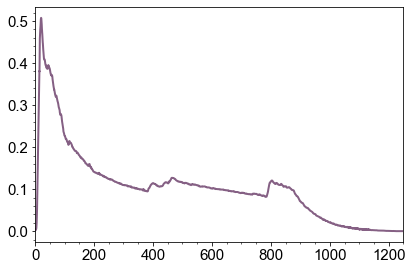

In [23]:
from matplotlib import pyplot as plt

dsp_sample_to_disparsed = r"C:\Users\yagi\OneDrive - 東京都公立大学法人\Research\theme\2212\15_3mmol_15ml_ss_dsp\3mmol_15ml_DMSO_ss_dsp_raw_bef_heat.csv"
s = CO2DspExp().set_csv(dsp_sample_to_disparsed, 10).set_flow_rate(50.54).set_timeunit("min")
dsp_sample_to_clear = r"C:\Users\yagi\OneDrive - 東京都公立大学法人\Research\theme\2212\15_3mmol_15ml_ss_dsp\3mmol_15ml_DMSO_ss_dsp_raw_aft_heat.csv"
sa = CO2DspExp().set_csv(dsp_sample_to_clear, 10).set_flow_rate(50.54).set_timeunit("min")
dsp_blank = r"C:\Users\yagi\OneDrive - 東京都公立大学法人\Research\theme\2212\15_3mmol_15ml_ss_dsp\blank_15ml_DMSO_ss_dsp_raw.csv"
b = CO2DspExp().set_csv(dsp_blank, 10).set_flow_rate(50.54).set_timeunit("min").set_normalize(0, 20.367111)


print("sampl1: "+str(s.get_co2des()*1000))
print("sampl2: "+str(sa.get_co2des()*1000))
print("Blank : "+str(b.get_co2des()*1000))
print("diffs : "+str(s.get_co2des()*1000-b.get_co2des()*1000+sa.get_co2des()*1000))

def graph_gen(xydata, plot_range, xlabel, ylabel, norm=False, space=1):
    fig = plt.figure()
    
    # font設定
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 15
    
    # color設定
    color_table = ["#856084", "#ca5310", "#5575c7", "#16735a", "#e4b334"]
    color_used = 0
    length = len(xydata)
    
    if norm:
        plt.xlabel(xlabel)
        plt.ylabel("Normalized " + ylabel)
        index = 0
        for i in xydata:
            plt.plot(i["x"], series_norm(i["y"], index), color=color_table[color_used%5], lw=2, label=i["name"])
            color_used += 1
            index += space
    else:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        for i in xydata:
            plt.plot(i["x"], i["y"], color=color_table[color_used%5], lw=2, label=i["name"])
            color_used += 1
    #plt.legend(bbox_to_anchor=(1, 1.1), loc='best', borderaxespad=0.5, fontsize=15)
    plt.minorticks_on()
    if plot_range[0] is not None:
        plt.xlim(plot_range[0][0], plot_range[0][1])
    if plot_range[1] is not None:
        plt.ylim(plot_range[1][0], plot_range[1][1])
    plt.tight_layout()
    Export_filename = r"C:\Users\yagi\OneDrive - 東京都公立大学法人\Research\theme\2212\15_3mmol_15ml_ss_dsp\graph_aft_heat.png"
    fig.patch.set_alpha(1)
    fig.show()
    fig.savefig(Export_filename, transparent=True, dpi = 400)


#graph_gen([{"name": "bef_heat", "x": s.elapsed["time"], "y": s.conc["value"]}, {"name": "Blank", "x": b.elapsed_applied["time"], "y": b.conc_applied["value"]}], [[0,500], [0,2]], "", "", norm=False, space=1)
graph_gen([{"name": "aft_heat", "x": sa.elapsed["time"], "y": sa.conc["value"]}], [[0,1250], None], "", "", norm=False, space=1)